In [1]:
import numpy as np
from scipy.spatial import distance_matrix

import matplotlib.pyplot as plt

import sys
sys.path.insert(0, '../fem')
from GRF_new import *

In [2]:
GRFparams = {'d': 2,
             'l': np.random.uniform(),
             'lowerbound': None,
             'upperbound': None}
print(GRFparams['l'])

0.3528267127919581


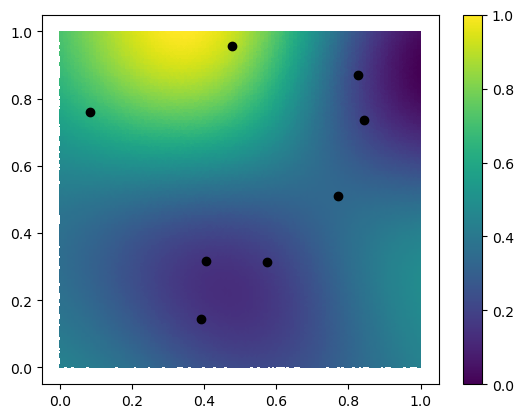

In [4]:
# func = GRF.RBFint()
grf = GRF(**GRFparams)
X, Y = np.mgrid[0:1:100*1j, 0:1:100*1j]
x_i = np.vstack([X.ravel(), Y.ravel()]).T
grf.RBFint_scaled()(x_i)
plt.tripcolor(x_i[:,0], x_i[:,1], grf.RBFint_scaled()(x_i))
plt.scatter(grf.x_grid[:,0], grf.x_grid[:,1], color='black')
plt.colorbar()

In [5]:
X, Y = np.mgrid[0:1:100*1j, 0:1:100*1j]
x_i = np.array([0.5,0.5])
GRF(**GRFparams).RBFint_pointwise_scaled()(x_i)

0.4006298784914617

In [12]:
simparams = {'d': 2}
trainingdataparams = {'N_samples': 10000}

In [7]:
thetaparams = {'l': np.random.uniform(),
               'lowerbound': 0.02,
               'upperbound': None}

fparams = {'l': np.random.uniform(),
           'lowerbound': None,
           'upperbound': None}

etaparams = {'l': np.random.uniform(),
             'lowerbound': None,
             'upperbound': None}

inputs = {'theta': thetaparams,
               'f': fparams,
               'eta': etaparams}

trainingdataparams['inputs'] = inputs

In [14]:
grfset = GRFset(**simparams, **trainingdataparams, **inputs['theta'])